# Ok, let's get serious

First, let's import a few libs we will use to make the graphs:

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint


Then, let's open the raw data file and read all the content. The beginning is pretty simple: I replace all the | and = and ; with spaces and then split along spaces to get an array of the single values of each record.

Then we clean a bit. I need to explain the source of some bad data:

1. I messed up the recording and ended up with two times the data (I thought the file recording had failed at first). 
2. It sends all its history every time, and this includes some history I did not erase where I was testing the sensors or the data dump and they will typically be records that are much closer to each other than the normal 30 minutes
3. The first line will typically be garbled, maybe a bug in the FTDI software I use. 

We will correct 1. at a later time but at this stage, we can parse the timestamp (that was set a bit creatively. I am surprised the clock accepts '0' as a valid month number or '31' as an hour) and check when less than 1000 seconds separate two records (the normal time should be 1800 seconds, or 30 minutes). This will happen on some valid occasions: the saboten was reset or the date changed, so in that case, we suppress a good packet. But it will mainly remove packets from the testing time.

For 3. I just remove lines with not enough records in them.

In [2]:
f = open("awanode-farmlab-2017-08-14.txt")
data=[]
times = list()
prevt=0
linei=0
for l in f.read().split('\n'):
    a=l.replace("|"," ").replace("="," ").replace(";"," ").split(" ")
    if len(a)>11:
        tim = [int(num) for num in a[1].split(':')]
        curt = tim[2]+tim[1]*60+tim[0]*3600
        if curt-prevt>1000:
            data.append((a[2],a[4],a[6],a[8],a[10],a[12], linei))
        prevt = curt
    linei+=1


Let's examine the data. First we need to convert it as 1-dimension arrays that matplotlib can use:

In [3]:
ytemp = [int(row[1]) for row in data]


Then we call the plotting functions:

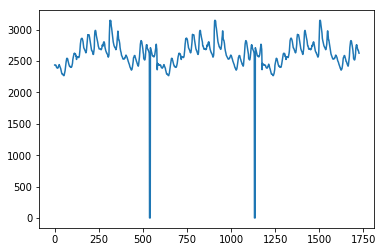

In [4]:
plt.plot(range(len(ytemp)), ytemp)
plt.show()

And we see that the data actually repeats itself 3 times! By exploring a bit the dataset, we can find the start of the last repeat, conveniently indicated by these erroneous zero readings.

In [5]:
pprint((data[1132:])[:20])


[('2', '2562', '0', '0', '4116', '412', 2472),
 ('3', '0', '0', '0', '4090', '0', 2473),
 ('4', '0', '0', '0', '4090', '0', 2474),
 ('1', '0', '0', '0', '4083', '0', 2475),
 ('3', '0', '0', '0', '4090', '0', 2478),
 ('2', '0', '0', '0', '4206', '290', 2523),
 ('2', '2712', '28', '67', '4206', '2477', 2536),
 ('3', '2700', '27', '72', '4206', '6', 2540),
 ('4', '2687', '25', '85', '4206', '0', 2541),
 ('5', '2681', '24', '87', '4206', '0', 2542),
 ('6', '2668', '24', '87', '4200', '0', 2543),
 ('7', '2656', '23', '89', '4200', '0', 2544),
 ('8', '2650', '23', '89', '4200', '0', 2545),
 ('9', '2637', '22', '90', '4200', '0', 2546),
 ('11', '2618', '22', '90', '4200', '0', 2547),
 ('12', '2606', '21', '90', '4200', '0', 2548),
 ('13', '2600', '21', '90', '4200', '0', 2549),
 ('14', '2587', '21', '90', '4200', '0', 2550),
 ('15', '2581', '22', '90', '4200', '0', 2551),
 ('16', '2581', '22', '91', '4200', '0', 2552)]


Here we are. Let's select only the data starting from after this series of zeros:

In [6]:
dww = data_we_want = data[1138:]

And let's make a more full-featured graph:

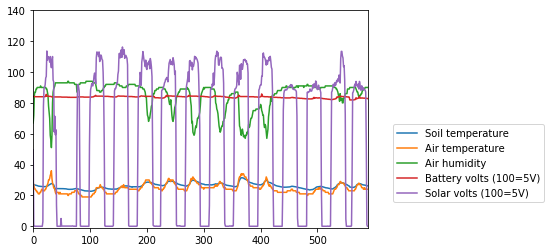

In [7]:
x = range(len(dww))
temp_soil = [float(row[1])/100.0 for row in dww]
temp_air = [float(row[2]) for row in dww]
hum = [float(row[3]) for row in dww]
vbat = [float(row[4])/50.0 for row in dww]
vsol = [float(row[5])/50.0 for row in dww]


xmin=0
xmax=len(x)
ymin = -1
ymax= 140
plt.plot(x, temp_soil, label="Soil temperature")
plt.plot(x, temp_air, label="Air temperature")
plt.plot(x, hum, label="Air humidity")
plt.plot(x, vbat, label="Battery volts (100=5V)")
plt.plot(x, vsol, label="Solar volts (100=5V)")
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 0.5))
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.show()

In [8]:
fout = open("awa_clean.csv", "w")
for d in dww:
    fout.write(str(d[1]))
    for rec in d[2:-1]:
        fout.write(", "+str(rec))
    fout.write("\n")
fout.close()